In [1]:
# Path de trabajo
WORK_DIR = '/home/dipa/proyectos/7506-Organizacion-de-Datos/tp_2'

In [2]:
import sys
sys.path.append(WORK_DIR)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.transform import transform_data
from lib import prepare_data
from lib import model_data


### Load data

In [24]:
### Se carga el file correspondiente
train = 'data/Entrenamieto_ECI_2020.csv'


df_train = prepare_data.load(os.path.join(WORK_DIR, train))
df_train['Target'] = np.where(df['Stage'] != 'Closed Lost', 1, 0)

In [25]:
test = 'data/Test_TP2_Datos_2020-2C.csv'
df_test = prepare_data.load(os.path.join(WORK_DIR, test))

## Explore data

### Product_Family

In [26]:
# Cunatas familias de productos hay en el set de entrenamiento?
df_train['Product_Family'].nunique()

227

In [29]:
df_test['Product_Family'].nunique()

94

In [42]:
df_train.groupby('Product_Family').agg({'Opportunity_ID': 'nunique'}).reset_index().merge(df_test.groupby('Product_Family').agg({'Opportunity_ID': 'nunique'}).reset_index(), how='inner', on='Product_Family')

,Product_Family,Opportunity_ID_x,Opportunity_ID_y
0,Product_Family_100,538,11
1,Product_Family_106,3,2
2,Product_Family_109,384,2
3,Product_Family_112,4,1
4,Product_Family_113,5,1
...,...,...,...
69,Product_Family_88,6,1
70,Product_Family_91,16,1
71,Product_Family_92,8,1
72,Product_Family_95,27,3


In [ ]:
# hay 20 fmilia de productos que no son compartidas entre el test y train, lo cual implica
#que cuando se haga el Target Encoding se van a tener que asiganar a un valor default

In [43]:
# Cuantas familia de productos hay por oportunidad?

gruped = df_train.groupby('Opportunity_ID').agg({'Product_Family': 'nunique'}).reset_index()
gruped.loc[gruped['Product_Family']>10,].sort_values(by='Product_Family', ascending=False)


,Opportunity_ID,Product_Family
1922,2008,36
4930,5123,25
5650,5890,13
3441,3580,12
6320,6614,12
188,192,11
4119,4288,11
7023,7373,11


In [ ]:
# hay oportunidades que tienen mas de una familia, se van a promediar cuando se haga el encoding

In [44]:
#  se agrupa por familia 

gruped_family_product = df_train.groupby('Product_Family')\
                                .agg({'Target':['mean','sum'],
                                      'Total_Amount':['mean','sum'],\
                                      'Product_Name':['nunique','count'], # cantidad de prodct q componen la familia y en cuantas oport aparecen
                                      'Opportunity_ID': ['nunique','count']})

gruped_family_product.sort_values(by=[('Opportunity_ID', 'count')], ascending=False)

Target       Total_Amount               Product_Name  \
                        mean  sum          mean           sum      nunique   
Product_Family                                                               
Product_Family_77   0.488476  657  2.962691e+06  3.919640e+09            5   
Product_Family_133  0.735789  919  2.765150e+05  3.453672e+08            5   
Product_Family_132  0.638270  487  4.872860e+06  3.717992e+09            5   
Product_Family_212  0.427673  272  1.842001e+06  1.171512e+09            5   
Product_Family_100  0.512116  317  9.236497e+05  5.717391e+08            5   
...                      ...  ...           ...           ...          ...   
Product_Family_182  1.000000    1  2.031250e+04  2.031250e+04            1   
Product_Family_46   1.000000    1  1.480500e+03  1.480500e+03            1   
Product_Family_241  1.000000    1  1.800000e+02  1.800000e+02            1   
Product_Family_177  1.000000    1  2.307500e+03  2.307500e+03            1   
Product_Family_245  1.000000    1  1.346400e+04  1.346400e+04            1   

                         Opportunity_ID        
                   count        nunique count  
Product_Family                                 
Product_Family_77   1345           1284  1345  
Product_Family_133  1249            795  1249  
Product_Family_132   763            698   763  
Product_Family_212   636            558   636  
Product_Family_100   619            538   619  
...                  ...            ...   ...  
Product_Family_182     1              1     1  
Product_Family_46      1              1     1  
Product_Family_241     1              1     1  
Product_Family_177     1              1     1  
Product_Family_245     1              1     1  

[227 rows x 8 columns]

In [ ]:
# como es la distibucion de tasa de exito de las oportunidades de Product_Family?

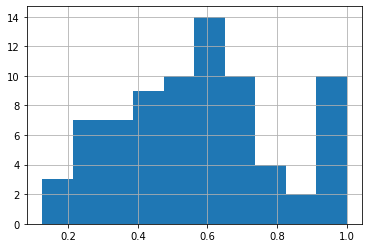

In [19]:
gruped_family_product.loc[gruped_family_product[('Opportunity_ID','count')] > 20,('Target', 'mean')].hist();

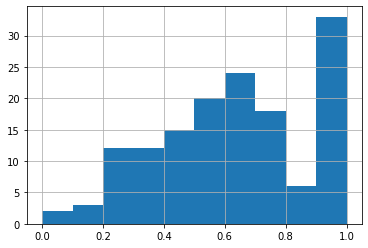

In [29]:
gruped_family_product.loc[gruped_family_product[('Opportunity_ID','count')] > 5,('Target', 'mean')].hist();

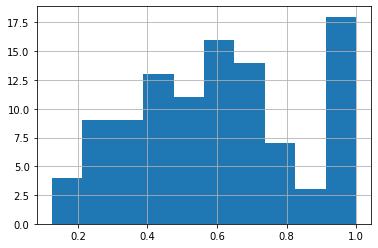

In [61]:
gruped_family_product.loc[gruped_family_product[('Opportunity_ID','count')] > 10,('Target', 'mean')].hist();

In [62]:
# conclusiones
Hay 227 familia de productos en train set y 94 en el test teniendo en comun 74 --> se va atener q asignar defualt a las faltantes
En 2335 oportunidades hay mas de una familia de productos --> cuando se agrupa se generan listas y caundo se hace encoding se va a promediar ente las familias
Hay variabilidad en la tasa de exito entre las familias y hay una cierta similitud en la forma eligiendo diferentes cantid de casos --> 10 pareceria un buen n para el encoding

104

In [ ]:
# Target  Encoding

In [52]:
gruped_family_product = df.groupby('Product_Family')\
                                .agg({'Target':'mean',
                                      'Opportunity_ID': 'nunique'})
code_map = dict()    # guarda el mapeo entre valores origibales y encoded


smooth = 10   # cantidad de casos que considero como valido

n = gruped_family_product['Opportunity_ID']

global_mu =  gruped_family_product['Target'].mean()  # promedio p tasa de exito de las familias



mu = gruped_family_product['Target']

mu_smoothed = (n * mu + smooth * global_mu) / (n + smooth)

code_map = mu_smoothed.to_dict()

default_value = mu_smoothed.mean()


0.6329469773504612

In [ ]:
gruped = df_train.groupby('Opportunity_ID').agg(Total_Taxable_Amount = ('Total_Taxable_Amount', 'first'),\
                                                 Total_Amount_sum =('Total_Amount', 'sum'),\
                                                 Region=('Region','first'),\
                                                 Target = ('Target', 'first'),\
                                                 Opportunity_Created_Date =('Opportunity_Created_Date','first'),\
                                                 Account_Created_Date = ('Account_Created_Date','first'),\
                                                 Planned_Delivery_End_Date=('Planned_Delivery_End_Date','max'),\
                                                 Product_Family=('Product_Family', lambda x: list(x))).reset_index()



In [53]:
helper = gruped.assign(Product_Family_Mean=[[code_map[k] if code_map.get(k) else default_value for k in row  ] for row in gruped['Product_Family']])

helper['Product_Family_Mean_sin_duplicados'] = helper['Product_Family_Mean'].map(lambda x: list(dict.fromkeys(x)))

In [54]:
helper

,Opportunity_ID,Total_Taxable_Amount,Total_Amount_sum,Region,Target,Opportunity_Created_Date,Account_Created_Date,Planned_Delivery_End_Date,Product_Family,Product_Family_Mean,Product_Family_Mean_sin_duplicados
0,0,5272800.0,5272800.00,EMEA,0,2015-12-07,2015-06-16,2016-06-30,[Product_Family_77],[0.48959230583554847],[0.48959230583554847]
1,1,48230.0,48230.00,EMEA,1,2015-12-07,2015-06-16,2016-01-20,[Product_Family_77],[0.48959230583554847],[0.48959230583554847]
2,2,83865.6,83865.60,Americas,1,2015-12-08,2015-04-21,2016-01-25,[Product_Family_81],[0.7422486260683915],[0.7422486260683915]
3,3,7421881.5,7421881.50,Americas,0,2015-12-08,2013-07-27,2018-03-31,[Product_Family_209],[0.2580788017886773],[0.2580788017886773]
4,4,13357192.5,13357192.50,Americas,0,2015-12-08,2013-07-27,2018-02-28,[Product_Family_209],[0.2580788017886773],[0.2580788017886773]
...,...,...,...,...,...,...,...,...,...,...,...
9836,12799,401700.0,401700.00,EMEA,1,2015-12-04,2013-07-27,2016-04-21,[Product_Family_77],[0.48959230583554847],[0.48959230583554847]
9837,12800,21332500.0,21332500.00,Americas,0,2015-12-04,2014-06-16,2016-12-30,"[Product_Family_164, Product_Family_158]","[0.30048219020958444, 0.32199988778805594]","[0.30048219020958444, 0.32199988778805594]"
9838,12801,299715.0,299715.00,EMEA,1,2015-12-04,2016-01-15,2016-04-08,"[Product_Family_85, Product_Family_85, Product...","[0.569935529749754, 0.569935529749754, 0.56993...",[0.569935529749754]
9839,12802,0.0,2346796.88,Americas,0,2015-12-05,2015-10-20,2016-04-29,[Product_Family_158],[0.32199988778805594],[0.32199988778805594]


In [55]:
gruped['Product_Family'] = helper['Product_Family_Mean_sin_duplicados'].map(lambda x: sum(x) / len(x))